In [28]:
using PyPlot
using Seaborn
using DataFrames
import JLD2
import CSV
import Base.Filesystem: joinpath
import DataStructures: counter

In [6]:
include("src\\NGSIM.jl")

find_pairs

In [9]:
DATA_PATH = "../data/trajdata_i101_trajectories-0750am-0805am"
JLD2.@load joinpath(DATA_PATH, "td.jld") td
#td = load_trajdata(1)
(S, id_lookup) = td_sparse(td);

## Find Pairs

In [38]:
pairs = CSV.read(joinpath(DATA_PATH, "pairs.csv"), nullable=false)
;

,car1,car2,start,end,length
1,1088,1093,4345,4455,111
2,1620,1623,6375,6501,127
3,1393,1398,5896,5922,27
4,1921,1926,7713,7774,62
5,1931,1957,8416,8475,60
6,2137,2141,8777,8846,70
7,1877,1908,8194,8363,170
8,1870,1876,7478,7905,428
9,604,622,2619,2675,57
10,1220,1224,4701,5133,433


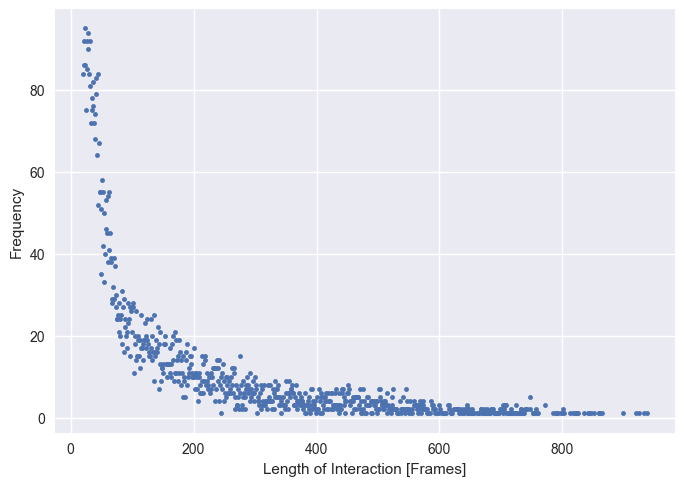

PyObject <matplotlib.text.Text object at 0x00000000014520B8>

In [42]:
len_counts = counter(pairs[:length])
lens = collect(keys(len_counts))
counts = collect(values(len_counts))

plot(lens, counts, ".")
xlabel("Length of Interaction [Frames]")
ylabel("Frequency")

## Velocities of (Supposedly) Interacting Cars

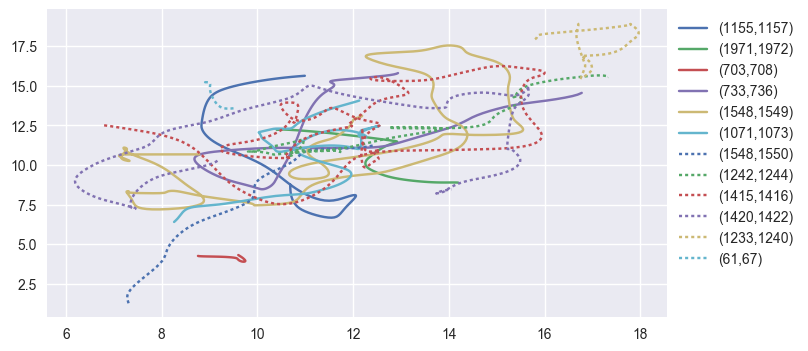

PyObject <matplotlib.legend.Legend object at 0x0000000000F98208>

In [16]:
fig = figure(figsize=(8, 4))
ax = fig[:gca]()

styles = repeat(["", ":"], inner=6)

for (i, ((ci, cj), (start_frame, end_frame))) in take(drop(pair_traj, rand(1:100)), 12) |> enumerate
    pt = full(S[start_frame:end_frame, [ci, cj]])
    vs = map(s -> s.v, pt)

    ax[:plot](vs[:, 1], vs[:, 2], styles[i], label=repr((ci, cj)))
end
ax[:legend](loc=2, bbox_to_anchor=(1,1))

## Velocities of Random Cars

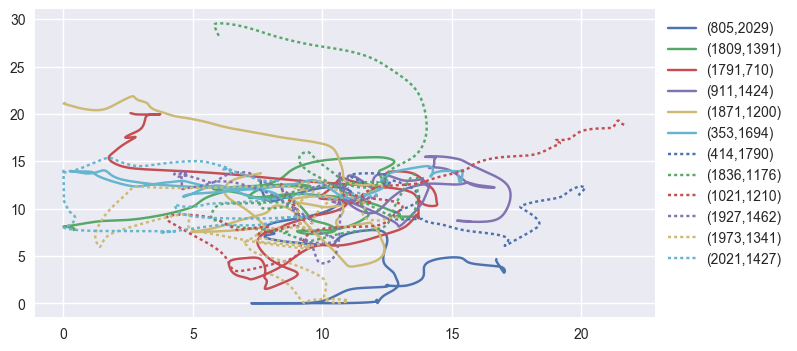

PyObject <matplotlib.legend.Legend object at 0x00000000010C19B0>

In [17]:
fig = figure(figsize=(8, 4))
ax = fig[:gca]()

styles = repeat(["", ":"], inner=6)

idxs_i = rand(1:S.n, length(styles))
idxs_j = rand(1:S.n, length(styles))

for (k, (i, j)) in zip(idxs_i, idxs_j) |> enumerate
    vs_i = map(s -> s.v, S.nzval[nzrange(S, i)])
    vs_j = map(s -> s.v, S.nzval[nzrange(S, j)])
    
    len = minimum(map(length, [vs_i, vs_j]))

    ax[:plot](vs_i[1:len], vs_j[1:len], styles[k], label=repr((i, j)))
end

ax[:legend](loc=2, bbox_to_anchor=(1,1))

### Plot Pairwise Trajectory

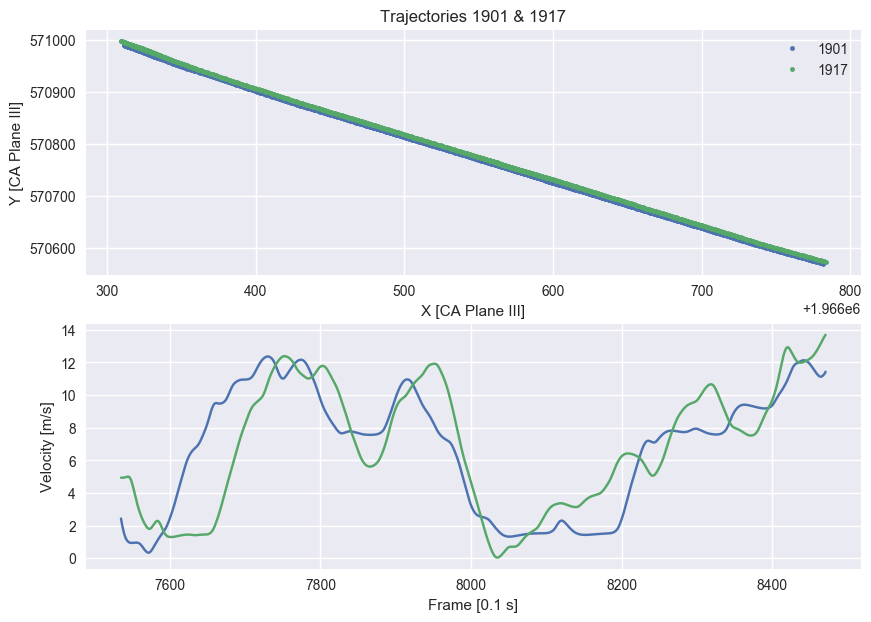

In [85]:
ind = indmax(pairs[:length])

ci = pairs[ind, :car1]
cj = pairs[ind, :car2]
start_frame = pairs[ind, :start]
end_frame = pairs[ind, :end]

pt = full(S[start_frame:end_frame, [ci, cj]])
vs = map(s -> s.v, pt)
xs = map(s -> s.posG.x, pt)
ys = map(s -> s.posG.y, pt)

fig, axs = subplots(2, 1, figsize=(10, 7))
axs[1][:plot](xs[:, 1], ys[:, 1], ".", label="$ci")
axs[1][:plot](xs[:, 2], ys[:,2], ".", label="$cj")
axs[2][:plot](start_frame:end_frame, vs[:, 1], start_frame:end_frame, vs[:, 2])

axs[1][:set_title]("Trajectories $ci & $cj")
axs[2][:set_xlabel]("Frame [0.1 s]")
axs[2][:set_ylabel]("Velocity [m/s]")
axs[1][:set_xlabel]("X [CA Plane III]")
axs[1][:set_ylabel]("Y [CA Plane III]")
axs[1][:legend]()

fig[:savefig](joinpath(DATA_PATH, "$(ci)_$(cj).png"))
;

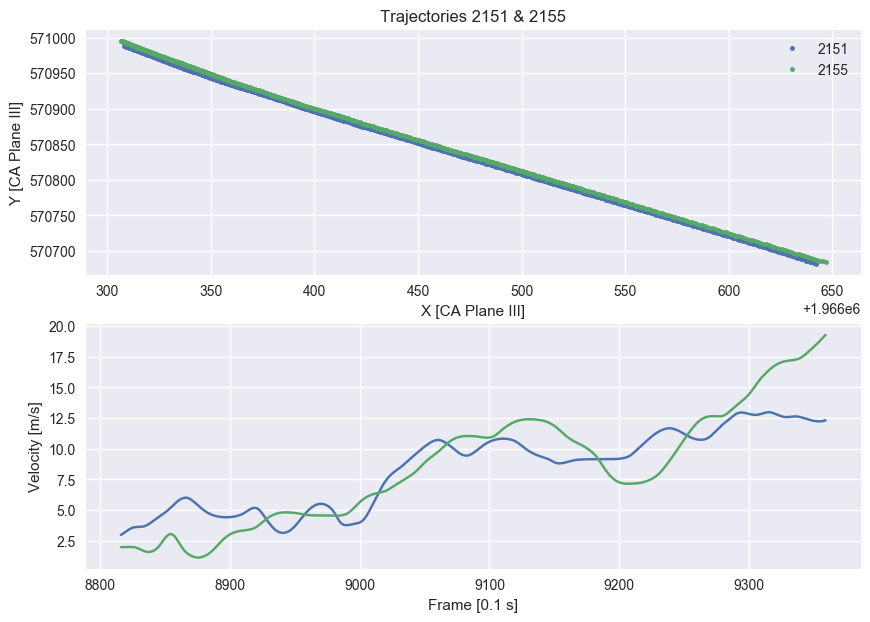

In [93]:
ind = rand(find(pairs[:length] .> 400))

ci = pairs[ind, :car1]
cj = pairs[ind, :car2]
start_frame = pairs[ind, :start]
end_frame = pairs[ind, :end]

pt = full(S[start_frame:end_frame, [ci, cj]])
vs = map(s -> s.v, pt)
xs = map(s -> s.posG.x, pt)
ys = map(s -> s.posG.y, pt)

fig, axs = subplots(2, 1, figsize=(10, 7))
axs[1][:plot](xs[:, 1], ys[:, 1], ".", label="$ci")
axs[1][:plot](xs[:, 2], ys[:,2], ".", label="$cj")
axs[2][:plot](start_frame:end_frame, vs[:, 1], start_frame:end_frame, vs[:, 2])

axs[1][:set_title]("Trajectories $ci & $cj")
axs[2][:set_xlabel]("Frame [0.1 s]")
axs[2][:set_ylabel]("Velocity [m/s]")
axs[1][:set_xlabel]("X [CA Plane III]")
axs[1][:set_ylabel]("Y [CA Plane III]")
axs[1][:legend]()

fig[:savefig](joinpath(DATA_PATH, "$(ci)_$(cj).png"))
;

### Correlations

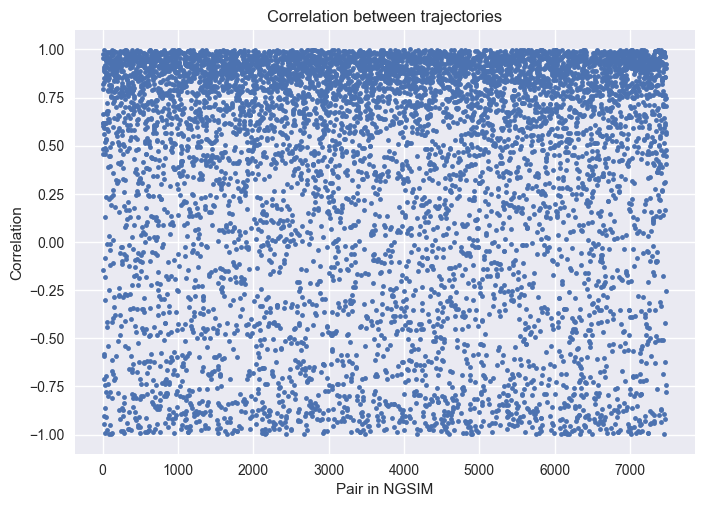

In [95]:
corrs = Vector(length(pair_traj))

for (i, ((ci, cj), (start_frame, end_frame))) in enumerate(pair_traj)
    pt = full(S[start_frame:end_frame, [ci, cj]])
    vs = map(s -> s.v, pt)
    corrs[i] = cor(vs[:, 1], vs[:, 2])
end

plot(corrs, ".")
xlabel("Pair in NGSIM")
ylabel("Correlation")
title("Correlation between trajectories")
savefig(joinpath(DATA_PATH, "corrs.png"))


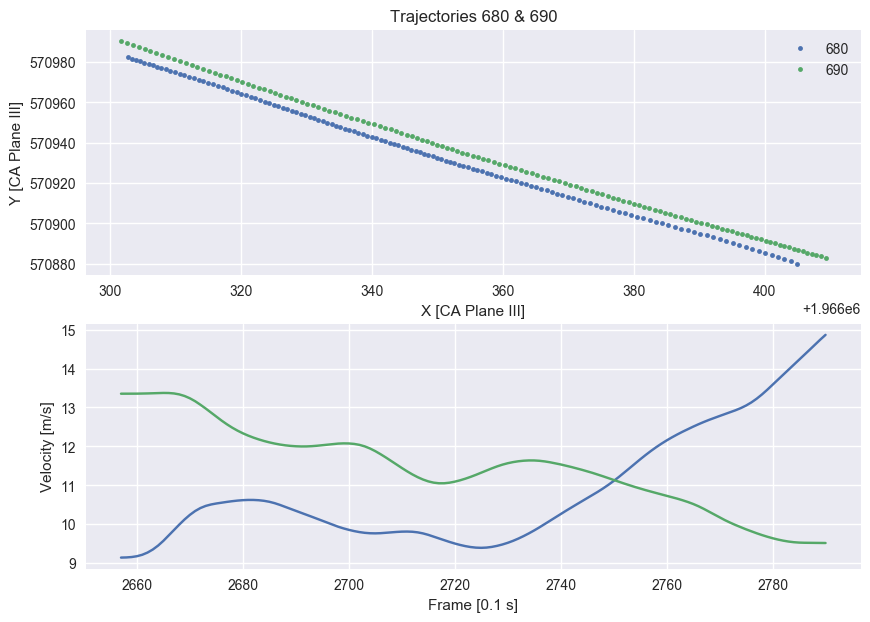

In [109]:
ind = rand(find( (corrs .< -0.75) .& (pairs[:length] .> 100) ))

ci = pairs[ind, :car1]
cj = pairs[ind, :car2]
start_frame = pairs[ind, :start]
end_frame = pairs[ind, :end]

pt = full(S[start_frame:end_frame, [ci, cj]])
vs = map(s -> s.v, pt)
xs = map(s -> s.posG.x, pt)
ys = map(s -> s.posG.y, pt)

fig, axs = subplots(2, 1, figsize=(10, 7))
axs[1][:plot](xs[:, 1], ys[:, 1], ".", label="$ci")
axs[1][:plot](xs[:, 2], ys[:,2], ".", label="$cj")
axs[2][:plot](start_frame:end_frame, vs[:, 1], start_frame:end_frame, vs[:, 2])

axs[1][:set_title]("Trajectories $ci & $cj")
axs[2][:set_xlabel]("Frame [0.1 s]")
axs[2][:set_ylabel]("Velocity [m/s]")
axs[1][:set_xlabel]("X [CA Plane III]")
axs[1][:set_ylabel]("Y [CA Plane III]")
axs[1][:legend]()

fig[:savefig](joinpath(DATA_PATH, "$(ci)_$(cj).png"))
;